# Mid-gestation fetal cortex dataset: Batch correction and Dimensionality reduction


__Upstream Steps__

* QC filter on cells
* expression filter on genes
* Normalization and log10 transformation by Scanpy
* HVG by Triku

__This notebook__

* Integration by Harmony
* Dimensionality reduction by
    * UMAP
    * Diffusion Map
    * Force-Directed Graph

# 1. Environment Set Up

## 1.1 Library upload

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import igraph as ig
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.sparse import csr_matrix, isspmatrix

import scanpy as sc
import scanpy.external as sce


## 1.2 Settings

In [ ]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [ ]:
#results_file = '/home/..../brainomics/Dati/3_AdataDimRed.h5ad'

## 1.3 Start Computation time

In [ ]:
print(datetime.now())

----

# 2. Read input files  

In [ ]:
#adata = sc.read('/home/..../brainomics/Data/2_AdataNorm.h5ad')
#adata = sc.read('/group/brainomics/course_material/Day2/data/Ongoing/2_AdataNorm.h5ad')

In [ ]:
print('Loaded Normalizes AnnData object: number of cells', adata.n_obs)
print('Loaded Normalizes AnnData object: number of genes', adata.n_vars)

print('Available metadata for each cell: ', adata.obs.columns)

----

# 3. Check for batch effects

In [ ]:
adata_check = adata.copy()

In [ ]:
sc.pp.pca(adata_check, n_comps=50, use_highly_variable=True, svd_solver='arpack')

In [ ]:
sc.pp.neighbors(adata_check, n_neighbors=30, n_pcs=25)

In [ ]:
sc.tl.umap(adata_check)

In [ ]:
sc.pl.umap(adata_check, color=['Donor', 'Layer'], size=10)

In [ ]:
plt.rcParams['figure.dpi'] = 120
sc.pl.umap(adata_check, color=['Donor'], size=10)

In [ ]:
del adata_check

----

# 4. Integration with Harmony

<div class="alert alert-block alert-info"> <b>NOTE: CORRECTING FOR 'Donor'</b> 
    
From the UMAP, it is visible a <b>batch effect related to the donor identity</b>, particularly in the region of migrating neurons. 
We therefore apply a batch correction using Harmony algorithm and 
    
</div>

## 4.1 Calculate PCA

In [ ]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

In [ ]:
sc.settings.set_figure_params(dpi=80)
sc.pl.pca_variance_ratio(adata)

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

## 4.2 Performing correction with Harmony

Harmony uses an iterative clustering approach to align cells from different batches. For each iteration: 

* soft k-means clustering to group cells from multiple datasets 
* computation for each cluster of a global centroid and a dataset-specific centroid 
* from the centroids, calculation of a correction factor 
* the correction factor is used to correct each cell with a cell-specific factor 

__References__
* [Harmony Quick Start](https://portals.broadinstitute.org/harmony/articles/quickstart.html) 
* [Harmony implementation in python](https://pypi.org/project/harmony-pytorch/) 
* [Harmony GitHub](https://github.com/immunogenomics/harmony) 

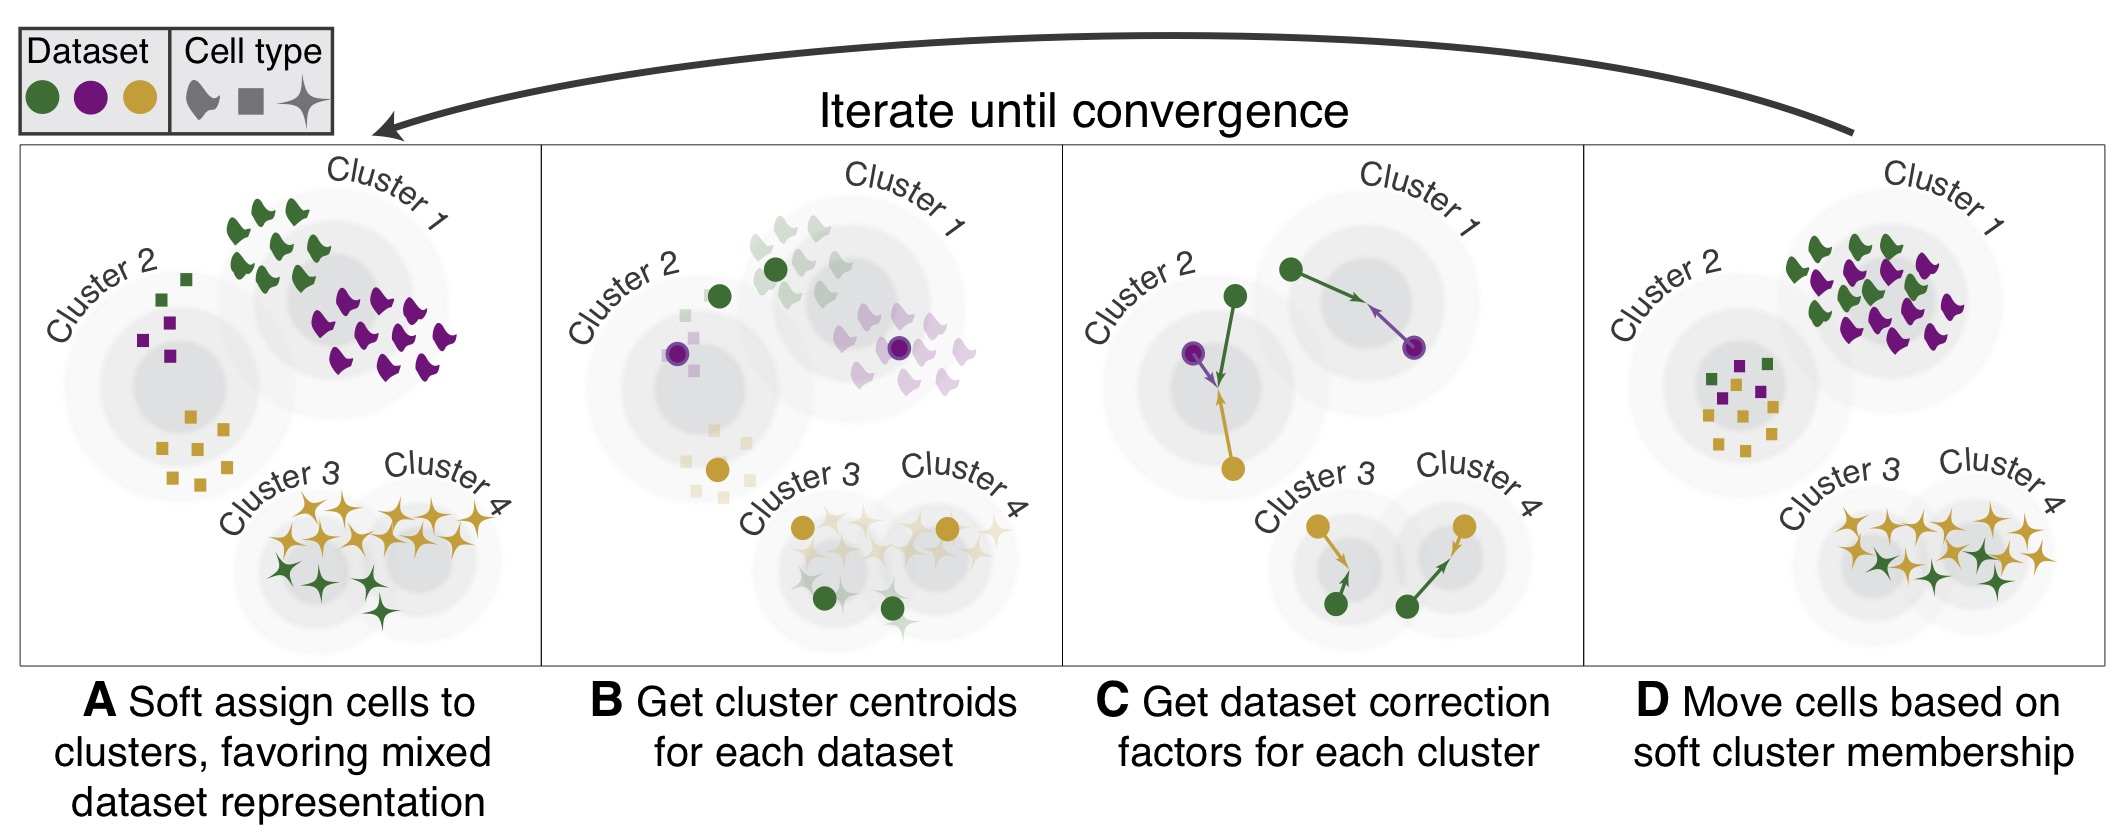

In [ ]:
sc.external.pp.harmony_integrate(adata, 'Donor')

## 4.3 Repeat plot with batch-corrected PCA

New corrected PC are saved in `.obs["X_pca_harmony"]`

In [ ]:
sc.pl.embedding(adata, basis="X_pca_harmony", color=['Donor'])

----

# 5. Calculate dimensionality reductions

## 5.1 Compute neighborhood graph

We compute the neighborhood graph of cells using the harmony-corrected PCA representation of the data. This identifies how similar a cell is to another cell, definying cells that are close from those that are not.

This step is propedeutic for UMAP plotting and for clustering. 

__Key parameters:__ 

* n_pcs: number of PC used for compute the kNN graph
* n_neighbors: number of neighbors. Larger neighbor values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range 5 to 50, with a choice of 10 to 15 being a sensible default.
* metrics: distance metric used in the calculation



In [ ]:
sc.pp.neighbors(adata, n_neighbors=80, n_pcs=20, use_rep="X_pca_harmony", key_added="harmony")
#sc.pp.neighbors(adata, n_neighbors=80, n_pcs=15, use_rep="X_pca_harmony", key_added="harmony", metric='cosine')

## 5.2 Calculate the UMAP

In [ ]:
sc.tl.umap(adata, neighbors_key="harmony", random_state=1)

## 5.3 Calculate the Diffusion Map

In [ ]:
sc.tl.diffmap(adata, neighbors_key="harmony")

## 5.4 Calculate the Force-directed graph

In [ ]:
#Takes quite some time 
sc.tl.draw_graph(adata, neighbors_key="harmony")

----

# 6. Visualize UMAP: Diagnostics and Metadata

In [ ]:
sc.pl.umap(adata, color=['n_genes_by_counts',"total_counts", 'pct_counts_mito', 'pct_counts_ribo'])

In [ ]:
sc.settings.set_figure_params(dpi=120)
sc.pl.umap(adata, color=['Donor', 'Cluster'])

----

# 7. Visualize Diffusion Map: Diagnostics and Metadata

In [ ]:
sc.settings.set_figure_params(dpi=80)
sc.pl.diffmap(adata, color=['n_genes_by_counts',"total_counts", 'pct_counts_mito', 'pct_counts_ribo'], 
             components=['2,3'])

In [ ]:
sc.settings.set_figure_params(dpi=120)
sc.pl.diffmap(adata, color=['Donor', 'Cluster'], components=['2,3'])

----

# 8. Visualize Force-directed graph: Diagnostics and Metadata

In [ ]:
sc.settings.set_figure_params(dpi=80)
sc.pl.draw_graph(adata, color=['n_genes_by_counts',"total_counts", 'pct_counts_mito', 'pct_counts_ribo'])

In [ ]:
sc.settings.set_figure_params(dpi=120)
sc.pl.draw_graph(adata, color=['Donor', 'Cluster'])

# 9. Visualize UMAP: Cell population markers

## 9.1 Functions for plotting markers in UMAP

In [ ]:
def selectMarkers(adataObj, mList):
    """  From a list of gene names select only the genes that are present in adata.var
    """
    #Select markers present in adata
    p = adataObj.var_names[adataObj.var_names.isin(mList) == True]
    #Keep the same order as input list
    p = [x for x in mList if x in p]   
    
    #Select missing genes
    ab = set(mList).difference(set(adataObj.var_names))
    
    #Print message
    if len(ab) == len(mList):
        print('\nAll markers are missing')
    else:
        print('\nThe following marker genes are missing: ', ab)
        
    return(p)

In [ ]:
def CustomUmap(adata, genes):
    genes = selectMarkers(adata, genes)
    sc.pl.umap(adata, color=genes, size=10, frameon=False,
               vmin='p1',  vmax='p99', layer='lognormcounts')

## 9.2 Top Triku genes

In [ ]:
TopTriku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(16).index
CustomUmap(adata, TopTriku)

## 9.3 Dictionary of marker genes

In [ ]:
marker_dictionary = {
    'Proliferation': ['MKI67', 'CDC20', 'HMGB2', 'CCNB1'], 
    'Apical Progenitors': ['FABP7', 'GLI3', 'PAX6', 'NES', 'SOX1', 'SOX2', 'SOX9', 'VIM'], 
    'Intermediate Progenitors': ['EOMES', 'ELAVL4', 'NHLH1', 'KCNQ3'], 
    'Pan-neuronal': ['DCX', 'STMN2', 'SYT1', 'SYP', 'GAP43', 'MEF2C',  'FOXG1'], 
    'ExcitatoryNeurons': ['EMX1', 'NEUROD1', 'NEUROD2', 'NEUROD6', 'NEUROG2', 'SLC17A7', 'TBR1', 'BCL11A', 'CUX1', 'CUX2', 'SATB2'], 
    'Inhibitory Neurons': ['DLX5', 'DLX6', 'DLX6-AS1', 'GAD1', 'GAD2', 'NKX2.1', 'SST', 'NPY', 'CALB1', 'CALB2', 'VIP', 'PVALB'], 
    'oRG': ['FAM107A', 'HOPX',  'PTPRZ1', 'TNC'], 
    'Astrocytes': ['GFAP', 'SLC1A3',  'S100B', 'AQP4', 'FGFR3', 'ALDH1L1']
    
    }

## 9.4 Marker gene plotting

In [ ]:
for Pop in marker_dictionary: 
    print("\n\n {}".format(Pop)) 
    CustomUmap(adata, marker_dictionary[Pop])

----

# 10. Save

## 10.1 Save AData

In [ ]:
adata.write(results_file)

## 10.2 Timestamp finished computations 

In [ ]:
print(datetime.now())

## 10.3 Save python and html versions

In [ ]:
nb_fname = '3_DimRed'

In [ ]:
%%bash -s "$nb_fname"
jupyter nbconvert "$1".ipynb --to="python"
jupyter nbconvert "$1".ipynb --to="html"